In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator

In [7]:
from surprise import SVD
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import BaselineOnly

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [3]:
train_df = pd.read_pickle('../data/train_df.pkl')
val_df = pd.read_pickle('../data/valid_df.pkl')
test_df = pd.read_pickle('../data/test_df.pkl')

In [5]:
train_df

,user_id,business_id,stars
0,--2HUmLkcNHZp0xw6AMBPg,yX0pOWG_Be9TjGnm0aihVA,5.0
1,--2HUmLkcNHZp0xw6AMBPg,u9R0_pvEkl7QGPJYH3j1sg,5.0
2,--2HUmLkcNHZp0xw6AMBPg,cHdJXLlKNWixBXpDwEGb_A,5.0
3,--2HUmLkcNHZp0xw6AMBPg,LR_99E7tVUfxqemvcGkDzw,3.0
4,--2HUmLkcNHZp0xw6AMBPg,lfyg98UFNYMVk18p6LIlkw,5.0
...,...,...,...
180554,zzO9aMo33jA3pPv8SoYskw,ylxqmxh2gO1yCpQkIk6o3A,5.0
180555,zzO9aMo33jA3pPv8SoYskw,5eK_pgro9_LxPYDoRVJnEA,2.0
180556,zzO9aMo33jA3pPv8SoYskw,evdJO0v9rvVixieNEnaeJg,5.0
180557,zzO9aMo33jA3pPv8SoYskw,frCxZS7lPhEnQRJ3UY6m7A,5.0


In [17]:
train_df.columns = ['userID', 'itemID','rating']
val_df.columns = ['userID', 'itemID','rating']
test_df.columns = ['userID', 'itemID','rating']

In [21]:
reader = Reader(rating_scale = (0.0, 5.0))
train_set = Dataset.load_from_df(train_df, reader).build_full_trainset()
val_set = Dataset.load_from_df(val_df, reader).build_full_trainset().build_testset()
test_set = Dataset.load_from_df(test_df, reader).build_full_trainset().build_testset()

In [9]:
train_set

### baseline

In [25]:
bsl_options = {'method': 'als','n_factors':200, 'n_epochs':30,'lr_all':0.005,'reg_all':0.1}
bias_baseline = BaselineOnly(bsl_options)
bias_baseline.fit(train_set)
predictions = bias_baseline.test(val_set)
accuracy.mse(predictions)

Estimating biases using als...
MSE: 1.4369


1.436931792432425

In [62]:
MSE_tune_baseline = {}
n_factors = [10,20,50]
n_epochs = [20,30,40]  # the number of iteration of the SGD procedure
# lr_all = [0.001, 0.003, 0.005] # the learning rate for all parameters
reg_all =  [0.1, 0.3,0.5] # the regularization term for all parameters


for n in n_epochs:
    for factor in n_factors:
        for reg in reg_all:
            print('Fitting n: {0}, factor: {1}, reg:{2}'.format(n, factor,reg))
            bsl_options = {'method': 'als','n_factors':factor, 'n_epochs':n,'lr_all':0.005,'reg_all':reg}
            bias_baseline = BaselineOnly(bsl_options)
            bias_baseline.fit(train_set)
            predictions = bias_baseline.test(val_set)
            MSE_tune_baseline[n,factor,reg] = accuracy.mse(predictions)

Fitting n: 20, factor: 10, reg:0.1
Estimating biases using als...
MSE: 1.4369
Fitting n: 20, factor: 10, reg:0.3
Estimating biases using als...
MSE: 1.4369
Fitting n: 20, factor: 10, reg:0.5
Estimating biases using als...
MSE: 1.4369
Fitting n: 20, factor: 20, reg:0.1
Estimating biases using als...
MSE: 1.4369
Fitting n: 20, factor: 20, reg:0.3
Estimating biases using als...
MSE: 1.4369
Fitting n: 20, factor: 20, reg:0.5
Estimating biases using als...
MSE: 1.4369
Fitting n: 20, factor: 50, reg:0.1
Estimating biases using als...
MSE: 1.4369
Fitting n: 20, factor: 50, reg:0.3
Estimating biases using als...
MSE: 1.4369
Fitting n: 20, factor: 50, reg:0.5
Estimating biases using als...
MSE: 1.4369
Fitting n: 30, factor: 10, reg:0.1
Estimating biases using als...
MSE: 1.4369
Fitting n: 30, factor: 10, reg:0.3
Estimating biases using als...
MSE: 1.4369
Fitting n: 30, factor: 10, reg:0.5
Estimating biases using als...
MSE: 1.4369
Fitting n: 30, factor: 20, reg:0.1
Estimating biases using als..

In [63]:
print(min(MSE_tune_baseline.items(), key=operator.itemgetter(1))[0])
print(f"MSE = {MSE_tune_baseline[min(MSE_tune_baseline.items(), key=operator.itemgetter(1))[0]]}")

(20, 10, 0.1)
MSE = 1.436931792125898


#### on test data

In [48]:
new_train_df = pd.concat([train_df,val_df])
new_train_set = Dataset.load_from_df(new_train_df, reader).build_full_trainset()

In [77]:
bsl_options = {'method': 'als','n_factors':10, 'n_epochs':20,'lr_all':0.005,'reg_all':0.1}
bias_baseline = BaselineOnly(bsl_options)
bias_baseline.fit(new_train_set)
predictions = bias_baseline.test(test_set)
accuracy.mse(predictions)

Estimating biases using als...
MSE: 1.5203


1.5203183139363428

In [78]:
baseline_predict_df = pd.DataFrame(predictions)
baseline_predict_df = baseline_predict_df.drop(["r_ui","details"],1)
baseline_predict_df.columns = ["userId","itemId","predict"]

In [80]:
baseline_predict_df.to_csv('../data/baseline_predict_df.csv')

### biased SGD model:


In [26]:
bias_sgd = SVD(n_factors=200 ,n_epochs=30,lr_all=0.005,reg_all=0.02)
bias_sgd.fit(train_set)
predictions = bias_sgd.test(val_set)
accuracy.mse(predictions)

MSE: 1.4836


1.483566559172792

In [30]:
n_factors_all = [10,30,50,100,150,200]
mse_n_factor = []
for n in n_factors_all:
    bias_sgd = SVD(n_factors=n ,n_epochs=30,lr_all=0.005,reg_all=0.02)
    bias_sgd.fit(train_set)
    predictions = bias_sgd.test(val_set)
    mse_n_factor.append(accuracy.mse(predictions))

MSE: 1.4270
MSE: 1.4509
MSE: 1.4618
MSE: 1.4653
MSE: 1.4752
MSE: 1.4808


Text(0, 0.5, 'MSE')

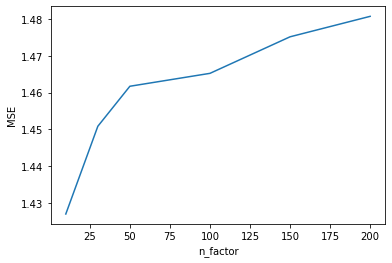

In [32]:
plt.plot(n_factors_all,mse_n_factor)
plt.xlabel("n_factor")
plt.ylabel("MSE")

In [34]:
n_epochs = [10,20,30,40,50]
mse_n_epochs = []
for n in n_epochs:
    bias_sgd = SVD(n_factors=200 ,n_epochs=n,lr_all=0.005,reg_all=0.02)
    bias_sgd.fit(train_set)
    predictions = bias_sgd.test(val_set)
    mse_n_epochs.append(accuracy.mse(predictions))

MSE: 1.4693
MSE: 1.4702
MSE: 1.4816
MSE: 1.5008
MSE: 1.4864


Text(0, 0.5, 'MSE')

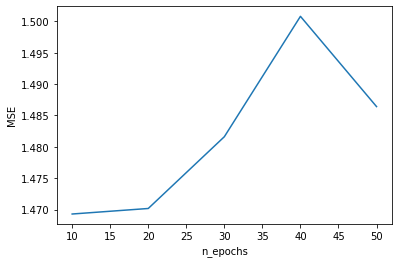

In [35]:
plt.plot(n_epochs,mse_n_epochs)
plt.xlabel("n_epochs")
plt.ylabel("MSE")

MSE: 1.4898
MSE: 1.4685
MSE: 1.4867
MSE: 1.4989
MSE: 1.4730
MSE: 1.4860


Text(0, 0.5, 'MSE')

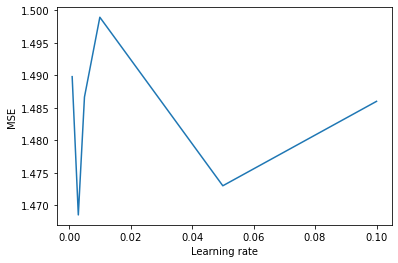

In [54]:
lr_all = [0.001, 0.003, 0.005,0.01,0.05,0.1] 
mse_lr = []
for lr in lr_all:
    bias_sgd = SVD(n_factors=200 ,n_epochs=30,lr_all=lr,reg_all=0.02)
    bias_sgd.fit(train_set)
    predictions = bias_sgd.test(val_set)
    mse_lr.append(accuracy.mse(predictions))
    
plt.plot(lr_all,mse_lr)
plt.xlabel("Learning rate")
plt.ylabel("MSE")

MSE: 1.4927
MSE: 1.4497
MSE: 1.4324
MSE: 1.4269
MSE: 1.4362


Text(0, 0.5, 'MSE')

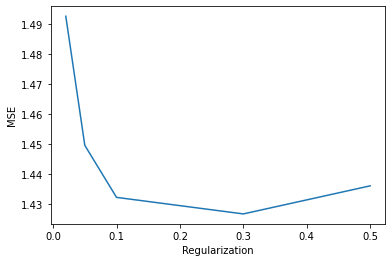

In [56]:
reg_all =  [0.02, 0.05, 0.1, 0.3, 0.5]
mse_reg = []
for reg in reg_all:
    bias_sgd = SVD(n_factors=200 ,n_epochs=30,lr_all=0.005,reg_all=reg)
    bias_sgd.fit(train_set)
    predictions = bias_sgd.test(val_set)
    mse_reg.append(accuracy.mse(predictions))
    
plt.plot(reg_all,mse_reg)
plt.xlabel("Regularization")
plt.ylabel("MSE")

In [58]:
MSE_tune = {}
n_factors = [10,20,50]
n_epochs = [20,30,40]  # the number of iteration of the SGD procedure
# lr_all = [0.001, 0.003, 0.005] # the learning rate for all parameters
reg_all =  [0.1, 0.3,0.5] # the regularization term for all parameters


for n in n_epochs:
    for factor in n_factors:
        for reg in reg_all:
            print('Fitting n: {0}, factor: {1}, reg:{2}'.format(n, factor,reg))
            algo = SVD(n_epochs = n, n_factors=factor,lr_all=0.005,reg_all = reg)
            algo.fit(train_set)
            predictions = algo.test(val_set)
            MSE_tune[n,factor,reg] = accuracy.mse(predictions)

Fitting n: 20, factor: 10, reg:0.1
MSE: 1.4195
Fitting n: 20, factor: 10, reg:0.3
MSE: 1.4287
Fitting n: 20, factor: 10, reg:0.5
MSE: 1.4416
Fitting n: 20, factor: 20, reg:0.1
MSE: 1.4190
Fitting n: 20, factor: 20, reg:0.3
MSE: 1.4298
Fitting n: 20, factor: 20, reg:0.5
MSE: 1.4418
Fitting n: 20, factor: 50, reg:0.1
MSE: 1.4226
Fitting n: 20, factor: 50, reg:0.3
MSE: 1.4305
Fitting n: 20, factor: 50, reg:0.5
MSE: 1.4422
Fitting n: 30, factor: 10, reg:0.1
MSE: 1.4170
Fitting n: 30, factor: 10, reg:0.3
MSE: 1.4234
Fitting n: 30, factor: 10, reg:0.5
MSE: 1.4352
Fitting n: 30, factor: 20, reg:0.1
MSE: 1.4178
Fitting n: 30, factor: 20, reg:0.3
MSE: 1.4236
Fitting n: 30, factor: 20, reg:0.5
MSE: 1.4353
Fitting n: 30, factor: 50, reg:0.1
MSE: 1.4225
Fitting n: 30, factor: 50, reg:0.3
MSE: 1.4237
Fitting n: 30, factor: 50, reg:0.5
MSE: 1.4355
Fitting n: 40, factor: 10, reg:0.1
MSE: 1.4203
Fitting n: 40, factor: 10, reg:0.3
MSE: 1.4254
Fitting n: 40, factor: 10, reg:0.5
MSE: 1.4354
Fitting n: 40

In [59]:
print(min(MSE_tune.items(), key=operator.itemgetter(1))[0])
print(f"MSE = {MSE_tune[min(MSE_tune.items(), key=operator.itemgetter(1))[0]]}")

(30, 10, 0.1)
MSE = 1.4169747769313954


#### on test data

In [81]:
bias_sgd = SVD(n_factors=10 ,n_epochs=30,lr_all=0.005,reg_all=0.1)
bias_sgd.fit(new_train_set)
predictions = bias_sgd.test(test_set)
accuracy.mse(predictions)

MSE: 1.4938


1.493840632629824

In [83]:
sgd_predict_df = pd.DataFrame(predictions)
sgd_predict_df = sgd_predict_df.drop(["r_ui","details"],1)
sgd_predict_df.columns = ["userId","itemId","predict"]

In [85]:
sgd_predict_df.to_csv('../data/sgd_predict_df.csv')

In [86]:
pd.DataFrame(predictions)

,uid,iid,r_ui,est,details
0,--2HUmLkcNHZp0xw6AMBPg,APXWKd1N-COyUdncd_FdyQ,5.0,4.808096,{'was_impossible': False}
1,--4rAAfZnEIAKJE80aIiYg,HTaA1mo9cB1dXMwfJC6yKg,1.0,2.060438,{'was_impossible': False}
2,--CIuK7sUpaNzalLAlHJKA,8Zqh2jwtncA3N4fWEMTvZQ,4.0,4.425357,{'was_impossible': False}
3,--Nnm_506G_p8MxAOQna5w,tIOjJWfu4Dqz-FIzXHRvCg,3.0,3.756813,{'was_impossible': False}
4,--mUBPK_NdRNVyhDVoUIUA,W7Dt3b6H_pMIHfxn49Pkzg,1.0,3.264628,{'was_impossible': False}
...,...,...,...,...,...
19495,zy7D8MZ8NwXO8uDraQby8g,frCxZS7lPhEnQRJ3UY6m7A,4.0,4.528318,{'was_impossible': False}
19496,zyebSPCZLUZHapi-dSHU5Q,wfxmuA7LbKZKVLV58EiWBw,2.0,3.606343,{'was_impossible': False}
19497,zz8rQaQvsZFZfAu-rPhLNw,h0bxE_VmJJvKKEEm4-NFRA,4.0,3.742852,{'was_impossible': False}
19498,zzF17hwmlFTuOa1Yagi-eg,umrDQGRNied77aVg29_fVw,5.0,4.030512,{'was_impossible': False}
